In [1]:
import BlackScholes as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ImpliedDrift as iD
import time
import variance_curve as vc

from rbergomi import rBergomi
from matplotlib import cm

In [2]:
# Read the dataset

dates = np.array(["23_01_23.csv", "24_01_23.csv", "25_01_23.csv", "26_01_23.csv", "27_01_23.csv",
                  "30_01_23.csv", "06_02_23.csv", "13_02_23.csv", "21_02_23.csv"])

spot = np.array(pd.read_csv("spot.csv").Spot).flatten()
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])

index = 0
data = pd.read_csv(dates[index]); S0 = spot[index];
K = S0 * moneyness / 100

if index:
    maturities = np.array(data.Tenor).flatten()
    IV = np.array(data.drop(columns = ['Date', 'Tenor']))/100.

else:
    maturities = np.array(data['Exp Date']).flatten()
    IV = np.array(data.drop(columns = 'Exp Date'))/100.
    

maturities = maturities[maturities*365 <= 180]
    
nr = len(maturities); nc = len(K);

IV = IV[:nr]

param = np.array(pd.read_csv("rB_data.csv"))

In [3]:
def price(S, K, r, q, T):
    n = len(K)
    p = np.zeros(n)
    for i in range(n):
        p[i] = np.mean(np.maximum(S-K[i],0)*np.exp(-(r-q)*T))
    return p

In [4]:
nr = len(maturities); nc = len(K);
N = 25000; n = 365;
r = iD.r(maturities); q = iD.q(maturities)

steps = np.ceil(n*maturities).astype(int)
T = maturities[-1]
np.random.seed(index)

In [5]:
def f(x):
    
    np.random.seed(index)
    
    iv = np.zeros([nr,nc])
    rho, H, eta = x
    
    alpha = H - 0.5
    
    rB = rBergomi(n, N, T, alpha)
    xi = vc.variance_curve(rB.t[0], index)
    dW1 = rB.dW1(); dW2 = rB.dW2();    
    Ya = rB.Y(dW1)
    dZ = rB.dZ(dW1, dW2, rho)
    V = rB.V(Ya, xi, eta)
    
    S = rB.global_S(V, dZ, S0, steps, index)
    
    for i in range(nr):
        P = price(S[i,:], K, r[i], q[i], maturities[i])
        iv[i,:] = bs.BSImpliedVol(S0, K, maturities[i], r[i], q[i], P, Option_type = 1, toll = 1e-5)

    return np.mean(abs(IV-iv)/IV)*100, iv

In [6]:
H = 0.1024269698449348
rho = -0.8966542972191569
eta = 1.8347770754684745
err, iv = f(np.array([rho, H, eta]))

print(f"Mean percentage error: {err: .4f}%")

Mean percentage error:  4.0221%


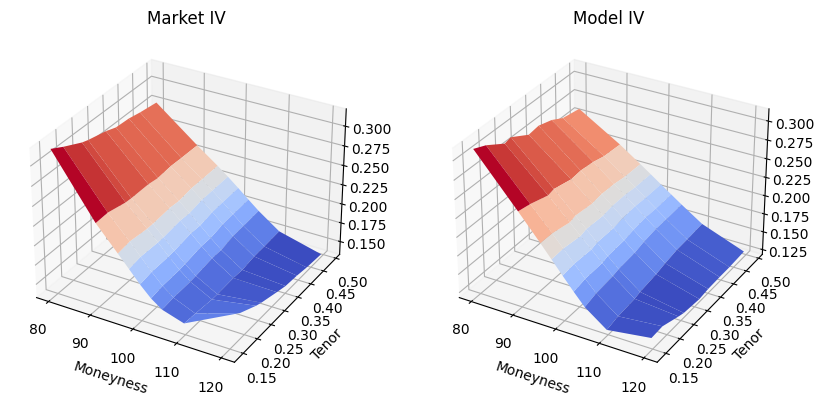

In [7]:
mesh_x, mesh_y = np.meshgrid(moneyness,maturities)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, IV, cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, iv, cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('Moneyness')
ax2.set_ylabel('Tenor')
ax2.set_title('Model IV')

plt.show()

In [8]:
H = np.array(pd.read_csv("parameters_for_bayes.csv"))[0][0]

In [9]:
rho = -0.9869705846702218
eta = 2.148388238602978
err, iv = f(np.array([rho, H, eta]))

print(f"Mean percentage error: {err: .4f}%")

Mean percentage error:  2.1518%


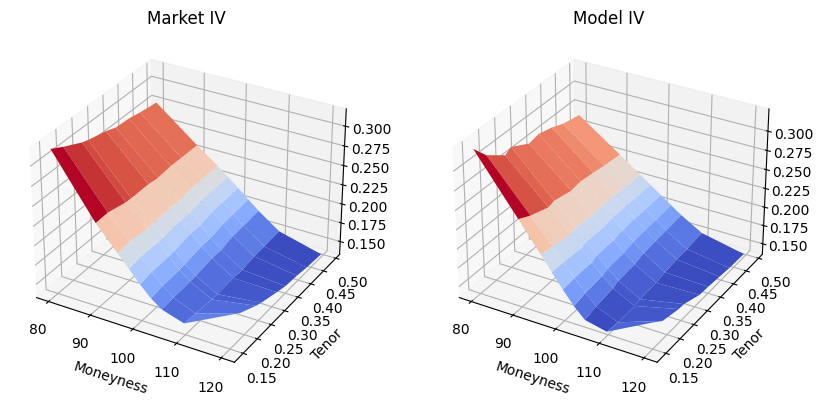

In [10]:
mesh_x, mesh_y = np.meshgrid(moneyness,maturities)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

ax1 = fig.add_subplot(121,projection='3d')
surf1 = ax1.plot_surface(mesh_x, mesh_y, IV, cmap=cm.coolwarm, antialiased=True)
ax1.set_xlabel('Moneyness')
ax1.set_ylabel('Tenor')
ax1.set_title('Market IV')

ax2 = fig.add_subplot(122,projection='3d')
surf2 = ax2.plot_surface(mesh_x, mesh_y, iv, cmap=cm.coolwarm, antialiased=True)
ax2.set_xlabel('Moneyness')
ax2.set_ylabel('Tenor')
ax2.set_title('Model IV')

plt.show()